# In-Depth Analysis 

## Loading Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split 

## Importing the data

In [2]:
recipes_df=pd.read_csv('recipes_df.csv')
recipes_df.set_index('id', inplace=True)
reviews_df=pd.read_csv('reviews_df.csv')
reviews_df.set_index('recipe_id', inplace=True)
tags_matrix=pd.read_csv('tags_matrix.csv')
tags_matrix.set_index('id', inplace=True)
ingredients_matrix=pd.read_csv('ingredients_matrix.csv')
ingredients_matrix.set_index('id', inplace=True)

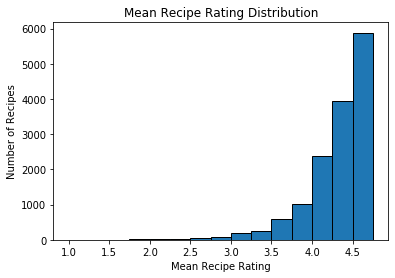

In [3]:
_ = plt.hist(reviews_df.groupby('recipe_id')['rating'].mean(), edgecolor='black', bins=np.arange(1, 5, 0.25))
_ = plt.title('Mean Recipe Rating Distribution')
_ = plt.xlabel('Mean Recipe Rating')
_ = plt.ylabel('Number of Recipes')

As we see from the histogram above, majority of the recipes have a mean rating of 4.2 and above.

## Predicting Recipe Rating by Recipe Tags Using Naive Bayes

We learnt from the data analysis before that the recipe tags is one of the features of the recipes dataset, and that recipes with 'pressure-canning' tag has the worst rating.<br>
We will dive deeper now and build a model to predict the recipe rating above or below 4.3 by  recipe tags.

In order to create the word vectors for all the tags present in a recipe, we can use tags_matrix with average recipe ratings that we built earlier.

In [4]:
avg_rating=reviews_df.groupby('recipe_id')['rating'].mean()
tags_matrix_rating=tags_matrix.join(avg_rating, how='left')
tags_matrix_rating.head(3)

,'crusts-pastry-dough-2','april-fools-day','marinades-and-rubs','turkish','oamc-freezer-make-ahead','gifts','cooking-mixes','indonesian','breads','60-minutes-or-less',...,'spreads','tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders','pressure-canning','plums',rating
id,,,,,,,,,,,,,,,,,,,,,
63986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.368421
43026,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.045455
23933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.833333


### Naive Bayes

Let's use multinomial Naive Bayes model to predict if the recipe rating is >= 4.2.

In [5]:
X=tags_matrix_rating.iloc[:,:-1].values
y=(tags_matrix_rating.rating >= 4.2).values.astype(np.int)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42) 
multinom = MultinomialNB()
multinom.fit(X_train,y_train)
y_pred = multinom.predict(X_test)
multinom.score(X_test, y_test)

0.7596375910463671

The mean accuracy on the given test data X_test and labels y_test is 75.96%.

In order to improve the model accuracy, we need to tune the hyperparameters: min_df and alpha.<br>
- min_df represents the minimum number of recipes a tag must appear in for it to be included in the vocabulary <br>
- alpha acts as a pseudo count for unseen tags. If alpha is too high, we will assign higher prior probability to unseen tags and add more bias towards the appearance of unseen tags

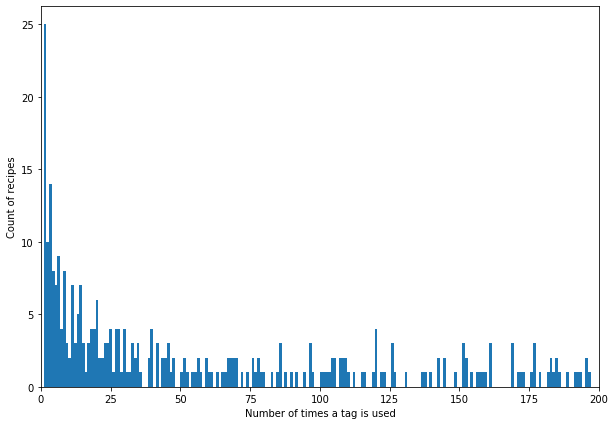

In [6]:
tags_count = tags_matrix_rating.drop('rating', axis = 1).sum(axis = 0)
fig, ax = plt.subplots(figsize = (10, 7))
ax.hist(tags_count.loc[tags_count < 200, ], bins = 200)
_ = plt.xlabel('Number of times a tag is used')
_ = plt.ylabel('Count of recipes')
ax.set_xlim(0, 200)
plt.show()

There are very many tags that appear only one time. Intuition tells us those aren't valuable. Let's drop the tags that are present in 45 recipes or less and rerun the model.

In [16]:
tags_matrix_rating1 = tags_matrix_rating.drop(tags_count[tags_count < 45].index, axis = 1)
tags_matrix_rating1.head(3)

,'marinades-and-rubs','oamc-freezer-make-ahead','gifts','cooking-mixes','breads','60-minutes-or-less','penne','sweet','low-sodium','long-grain-rice',...,'dips','toddler-friendly','spreads','tropical-fruit','cauliflower','canning','15-minutes-or-less','mixer','chowders',rating
id,,,,,,,,,,,,,,,,,,,,,
63986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.368421
43026,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.045455
23933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.833333


In [17]:
X=tags_matrix_rating1.iloc[:,:-1].values
y=(tags_matrix_rating1.rating >= 4.2).values.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42) 
multinom = MultinomialNB()
multinom.fit(X_train,y_train)
y_pred = multinom.predict(X_test)
multinom.score(X_test, y_test)

0.7653224373778647

By removing the tags present in less than 45 recipes we improved the model accuracy from 75.96% to 76.53%

Alpha is chosen to be a small value that simply avoids having zeros in the probability computations. We will use K-fold cross validation to find the best parameter alpha. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [9]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

In [10]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    bad = y == 0
    good = ~bad
    return prob[bad, 0].sum() + prob[good, 1].sum()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
df=tags_matrix_rating.iloc[:,:-1]
def make_xy(df, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(tags_matrix_rating)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (tags_matrix_rating.rating >= 4.2).values.astype(np.int)
    return X, y
X, y = make_xy(tags_matrix_rating)

In [12]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(tags_matrix_rating.shape[0]), train_size=0.7)
mask = np.zeros(tags_matrix_rating.shape[0], dtype=np.bool)
mask[itest] = True

We will now cross-validate over the regularization parameter alpha.

In [13]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 44 # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
accuracy = []
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(tags_matrix_rating, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    #model to be used
    mlb = MultinomialNB(alpha=alpha)
    #fitting data
    accuracy.append(cv_score(mlb,Xtrainthis,ytrainthis,log_likelihood))
accuracy_alpha = dict(zip(alphas,accuracy))
accuracy_alpha

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [ ]:
#X.reshape(X.shape[1:])
#X = X.transpose()

from sklearn.model_selection import GridSearchCV 
param_grid = {'alpha': np.arange(0.1,5)} 
mlb = MultinomialNB()
mlb_cv = GridSearchCV(mlb, param_grid, cv=5) 
mlb_cv.fit(X, y) 
mlb_cv.best_params_ 

In [ ]:
mlb_cv.best_score_

## Random Forest

Let's now predict recipe rating using a Random Forest Classifier.  
We need to create a combined_df containing all the feature columns first.

In [ ]:
combined_df=recipes_df[['minutes','n_steps','Calories','Total Fat','Sugars',
           'Sodium','Protein','Saturated Fat',
            'Total Carbohydrate']].merge(ingredients_matrix, right_index=True,left_index=True)
combined_df=combined_df.merge(tags_matrix,right_index=True,left_index=True)
combined_df=combined_df.join(avg_rating, how='left')
combined_df.head(3)

Now we have data with 653 features. We need to perform PCA dimension reduction to get rid of "noisy" features that don't add predictive value.

### PCA Dimension Reduction

Let's define how many intrinsic dimensions we need. (We will standardize the features first using the StandardScaler())

In [ ]:
samples=combined_df.iloc[:,:-1].values

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(samples)
features = range(pca.n_components_)
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(features, pca.explained_variance_)
plt.ylim(0,20)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.title('Explained Variances')
plt.xticks(range(0,654,20))
plt.show()

As we can see from the plot above, most features do not explain more than 2.5% of the variance, with 1 feature being highly descriptive and explaining power dropping after 20 features. So, we can make a conclusion that there are 20 intrinsic dimensions. Now let's perform dimension reduction of the data using PCA

In [ ]:
pca = PCA(n_components=20)
pca.fit(samples)
pca_features = pca.transform(samples)
print(pca_features.shape)

Now let's use a Random Forest classifier on the pca_features to classify the recipes as "good" (e.g. average rating > 4.2) or "bad".

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
X=pca_features
y=combined_df.rating.values.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state=42)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

The model accuracy of 83.43% is already higher than the Naive Bayes model. Let's see if we can improve it even more by tuning in hyperparameter